# Подготовка данных

Загружаем сырые данные, скачанные с [сайта kaggle.com](https://www.kaggle.com/code/artemboiko/5000-projects-ifc-rvt-datadrivenconstruction-io/notebook)

In [95]:
import pandas as pd

df_full = pd.read_csv("data/IFC_2000_300_Columns.csv", low_memory=False)
display(df_full.info())
df_full.head()

,Unnamed: 0,Unnamed: 0.1,Filename,IfcEntity,UniqueID,IFC version,GlobalId,OwnerHistory,ObjectPlacement,Representation,...,cpiFitMatchKey,Product code,ISOCD3766ShapeCode,ISOCD3766ShapeParameter_b,Omschrijving,Flche,System Classification,qv_SizingFlow_ls,dpTot_SizingFlow_Pa,Ebene
0,0,1000,beams_ifc,OdIfc4::IfcBeamStandardCase,1000.0,IFC4,0juf4qyggSI8rxA20Qwnsj,0.0,1001.0,1010.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1100,beams_ifc,OdIfc4::IfcBeamStandardCase,1100.0,IFC4,0juf4qyggSI8rxA20sznsj,0.0,1101.0,1110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1200,beams_ifc,OdIfc4::IfcBeamStandardCase,1200.0,IFC4,0juf4qyggSI8s4A20sznsj,0.0,1201.0,1210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1300,beams_ifc,OdIfc4::IfcBeamStandardCase,1300.0,IFC4,0juf4qyggSI8s4A20sznw6,0.0,1301.0,1310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1400,beams_ifc,OdIfc4::IfcBeamStandardCase,1400.0,IFC4,0juf4qyggSI8rxA20Qwnab,0.0,1401.0,1410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527526 entries, 0 to 1527525
Columns: 301 entries, Unnamed: 0 to Ebene
dtypes: float64(115), int64(2), object(184)
memory usage: 3.4+ GB


None

In [96]:
# drop `Unnamed XXX` columns
df_full = df_full.drop(df_full.columns[:2], axis=1)

## Имеющиеся сущности

In [112]:
df_full['IfcEntity'] = df_full['IfcEntity'].replace(r'^(.*?)::', '', regex=True)
df_full['IfcEntity'].value_counts().head(20)

IfcEntity
IfcDiscreteAccessory       335594
IfcBeam                    240784
IfcBuildingElementProxy    119628
IfcMember                   93677
IfcMechanicalFastener       89406
IfcWallStandardCase         77179
IfcPlate                    76144
IfcColumn                   65168
IfcReinforcingBar           51490
IfcFlowTerminal             42250
IfcFlowSegment              39048
IfcFlowFitting              33973
IfcCovering                 33717
IfcDistributionPort         32946
IfcSlab                     28021
IfcWall                     23065
IfcSpace                    21785
IfcFurnishingElement        20474
IfcWindow                   18139
IfcDoor                     16117
Name: count, dtype: int64

Количество стен

In [113]:
df_full[df_full['IfcEntity'].fillna('').str.contains('Wall')]\
    .value_counts('IfcEntity')

IfcEntity
IfcWallStandardCase    77179
IfcWall                23065
IfcCurtainWall           773
Name: count, dtype: int64

Объединяем колонки с похожими именами

In [127]:
def process_columns(df, callback):
    to_drop = []
    to_rename = {}
    for col in df.columns:
        new_col = callback(col)
        if new_col == col:
            continue

        if new_col is None:
            print(f"{col!r} -> **DELETE**")
            to_drop.append(col)
        elif new_col not in df.columns:
            print(f"{col!r} -> {new_col!r}")
            to_rename[col] = new_col
        else:
            print(f"{col!r} -> {new_col!r} (merge)")
            df[new_col] = df[new_col].fillna(df[col])
            to_drop.append(col)

    if to_drop:
        df.drop(to_drop, axis=1, inplace=True)

    if to_rename:
        df.rename(to_rename, axis=1, inplace=True)

def name_to_camel(name):
    if ' ' not in name:
        return name
    return ''.join(word.capitalize() if not word[0].isupper() else word 
                   for word in name.split(' '))

def remove_square_prefix(name):
    if not name.startswith('['):
        return name

    count = 0
    for idx, ch in enumerate(name):
        match ch:
            case '[':
                count += 1
            case ']':
                count -= 1
            case _:
                continue

        if count == 0:
            return name[idx + 1:].strip()
    raise ValueError(name)

def normalize_col_name(col):
    if col.startswith(r'\U') or col.startswith(r'\u'):
        return None
    if col.startswith('ISOCD3766'):
        col = col[len('ISOCD3766'):]
    col = remove_square_prefix(col)
    if '_' in col:
        col = col.replace('_', ' ')
    if ' ' in col:
        col = name_to_camel(col)
    return col

process_columns(df_full, normalize_col_name)

'ISOCD3766ShapeCode' -> 'ShapeCode'
'ISOCD3766ShapeParameterB' -> 'ShapeParameterB'


Выкидываем практически пустые колонки (меньше 1% заполненности)

In [180]:
def missing_ratio(ser):
    return ser.isna().sum() / ser.size

def drop_almost_missing_columns(df):
    almost_empty_columns = df\
        .apply(missing_ratio)\
        .T\
        .loc[lambda x: x >= 0.99].index.values
    
    if len(almost_empty_columns) > 0:
        print(f'Drop Almost Missing: {almost_empty_columns}')
        df.drop(almost_empty_columns, axis=1, inplace=True)

drop_almost_missing_columns(df_full)

In [181]:
def drop_constant_columns(df):
    # remove constant columns
    # const_columns = [col for col in df.columns.values if df[col].nunique() <= 1]
    const_columns = []
    for col in df.columns:
        try:
            if df[col].nunique() <= 1:
                const_columns.append(col)
        except ValueError:
            # skip multidimensional columns
            continue

    if len(const_columns) > 0:
        print(f"Drop Constants: {const_columns}")
        df.drop(const_columns, axis=1, inplace=True)

drop_constant_columns(df_full)

In [183]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527526 entries, 0 to 1527525
Columns: 218 entries, Filename to NetSurfaceArea
dtypes: float64(82), object(136)
memory usage: 2.5+ GB


Cохраняем полученные данные с объединенными колонками

In [177]:
df_full.to_csv("data/IFC_2000_300_Columns_MergedColumns.csv")

## Данные по балкам

Выкидываем все колонки с константами и пропусками

In [186]:
df_beams = df_full[lambda x: x['IfcEntity'] == 'IfcBeam'].copy()
drop_almost_missing_columns(df_beams)
drop_constant_columns(df_beams)

Drop Almost Missing: ['NominalDiameter' 'NominalLength' 'HasAssignments' 'Level' 'Offset'
 'Location' 'Manufacturer' 'BoltLength' 'WasherDiameter' 'SlottedHoleX'
 'SlottedHoleY' 'BoltHoleDiameter' 'BoltSize' 'NutType' 'WasherType'
 'BoltStandard' 'WasherName' 'BoltName' 'NutName' 'Host' 'ConnectedFrom'
 'ExtendToStructure' 'Size' 'ConnectedTo' 'ThermalTransmittance'
 'BarLength' 'SystemName' 'WasherCount' 'BoltCount' 'NutCount'
 'CompositionType' 'Roughness' 'HostId' 'SystemType' 'HasPorts'
 'BaseOffset' 'RoomBounding' 'OmniClassTitle' 'OmniClassNumber'
 'OverallWidth' 'OverallHeight' 'TopOffset' 'FlowDirection' 'ContainedIn'
 'NominalWidth' 'NominalHeight' 'ModelReference' 'Thickness'
 'WarrantyStartDate' 'InstallationDate' 'Angle' 'RelatedToMass' 'Color'
 'Workset' 'magiSystemCode' 'magiSystemName' 'Shape' 'Structural'
 'MagiInstallationElevation' 'MagiInstallationElevationAbs' 'LocationLine'
 'UnconnectedHeight' 'BaseConstraint' 'TopExtensionDistance'
 'BaseExtensionDistance' 'TopIs

In [187]:
df_beams.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240784 entries, 70 to 1527404
Data columns (total 91 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Filename               240784 non-null  object 
 1   UniqueID               240784 non-null  float64
 2   IFCVersion             240784 non-null  object 
 3   GlobalId               240784 non-null  object 
 4   OwnerHistory           240784 non-null  float64
 5   ObjectPlacement        240784 non-null  float64
 6   Representation         240784 non-null  float64
 7   Parent                 240760 non-null  object 
 8   Site                   240739 non-null  object 
 9   Name                   240583 non-null  object 
 10  BuildingStorey         240335 non-null  object 
 11  BoundingBoxMinX        238423 non-null  float64
 12  BoundingBoxMinY        238423 non-null  float64
 13  BoundingBoxMinZ        238423 non-null  float64
 14  BoundingBoxMaxX        238423 non-null 

<Axes: >

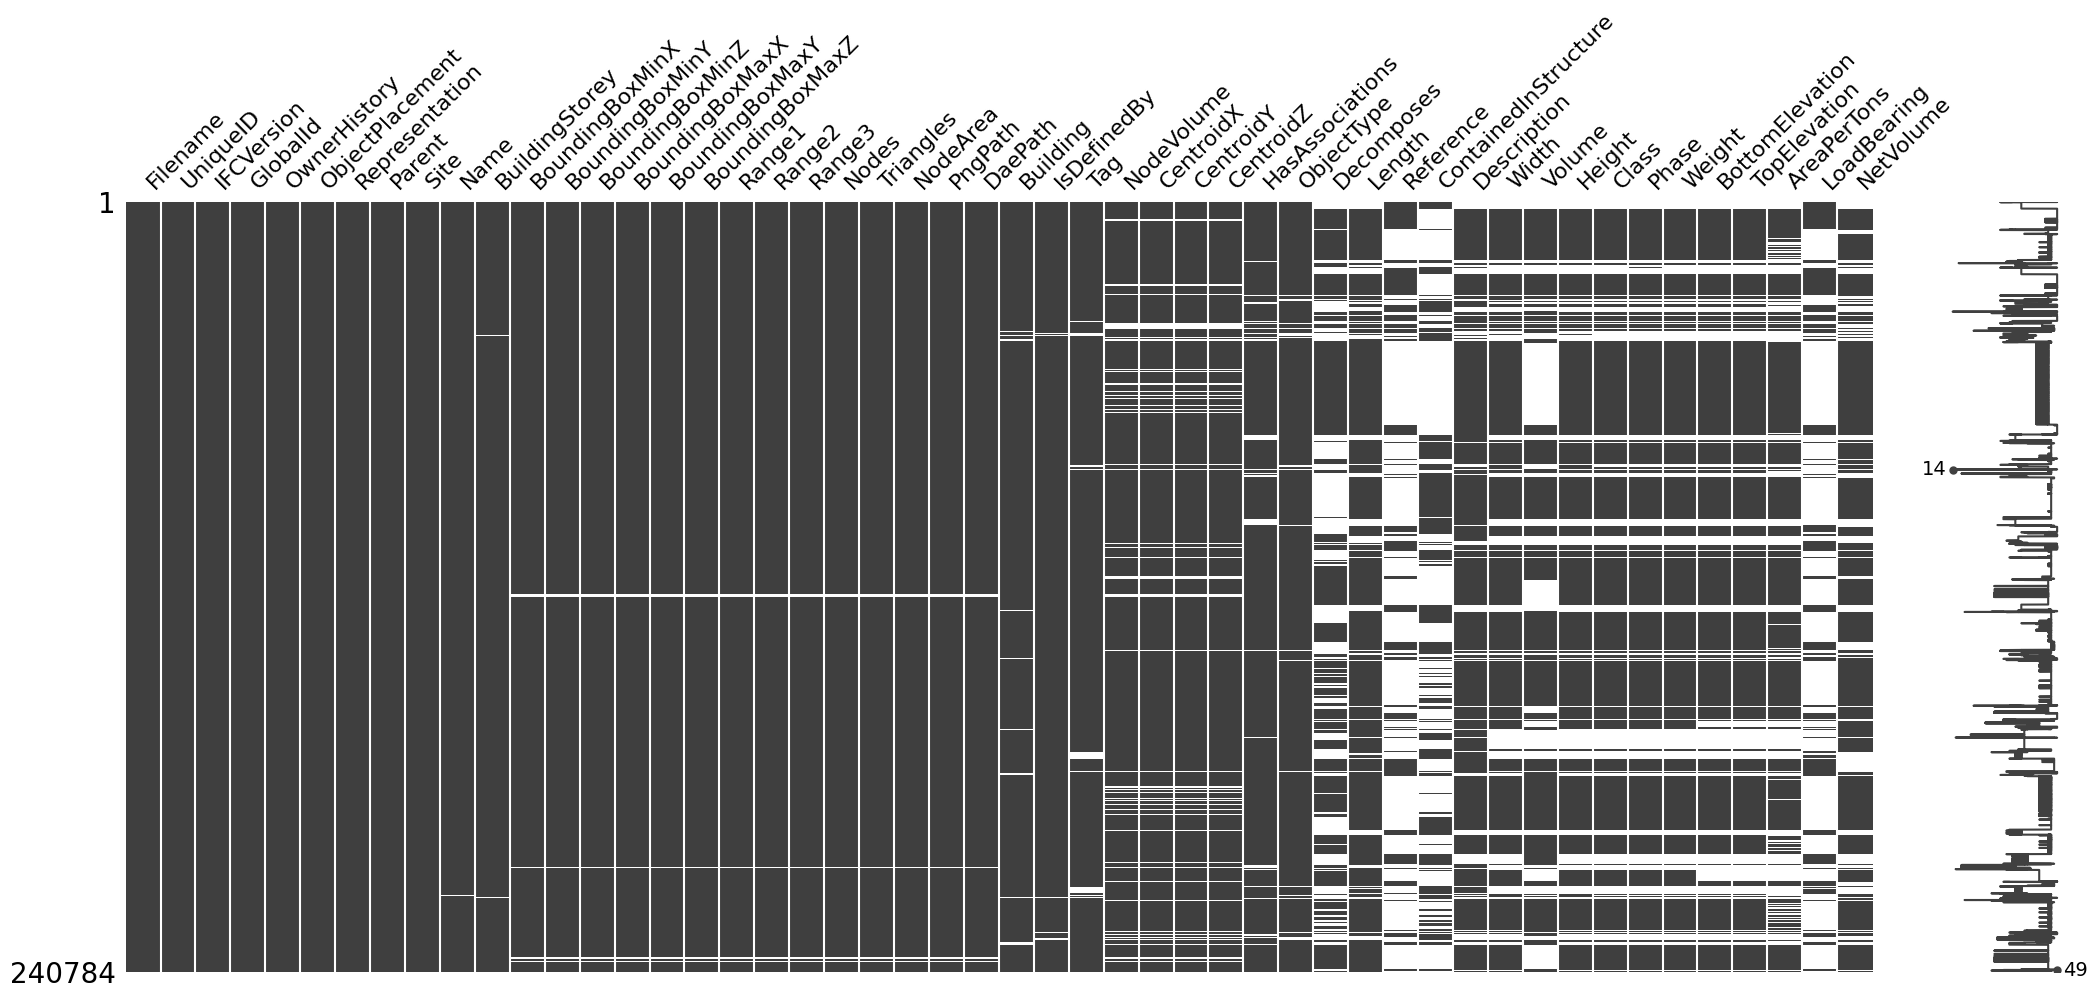

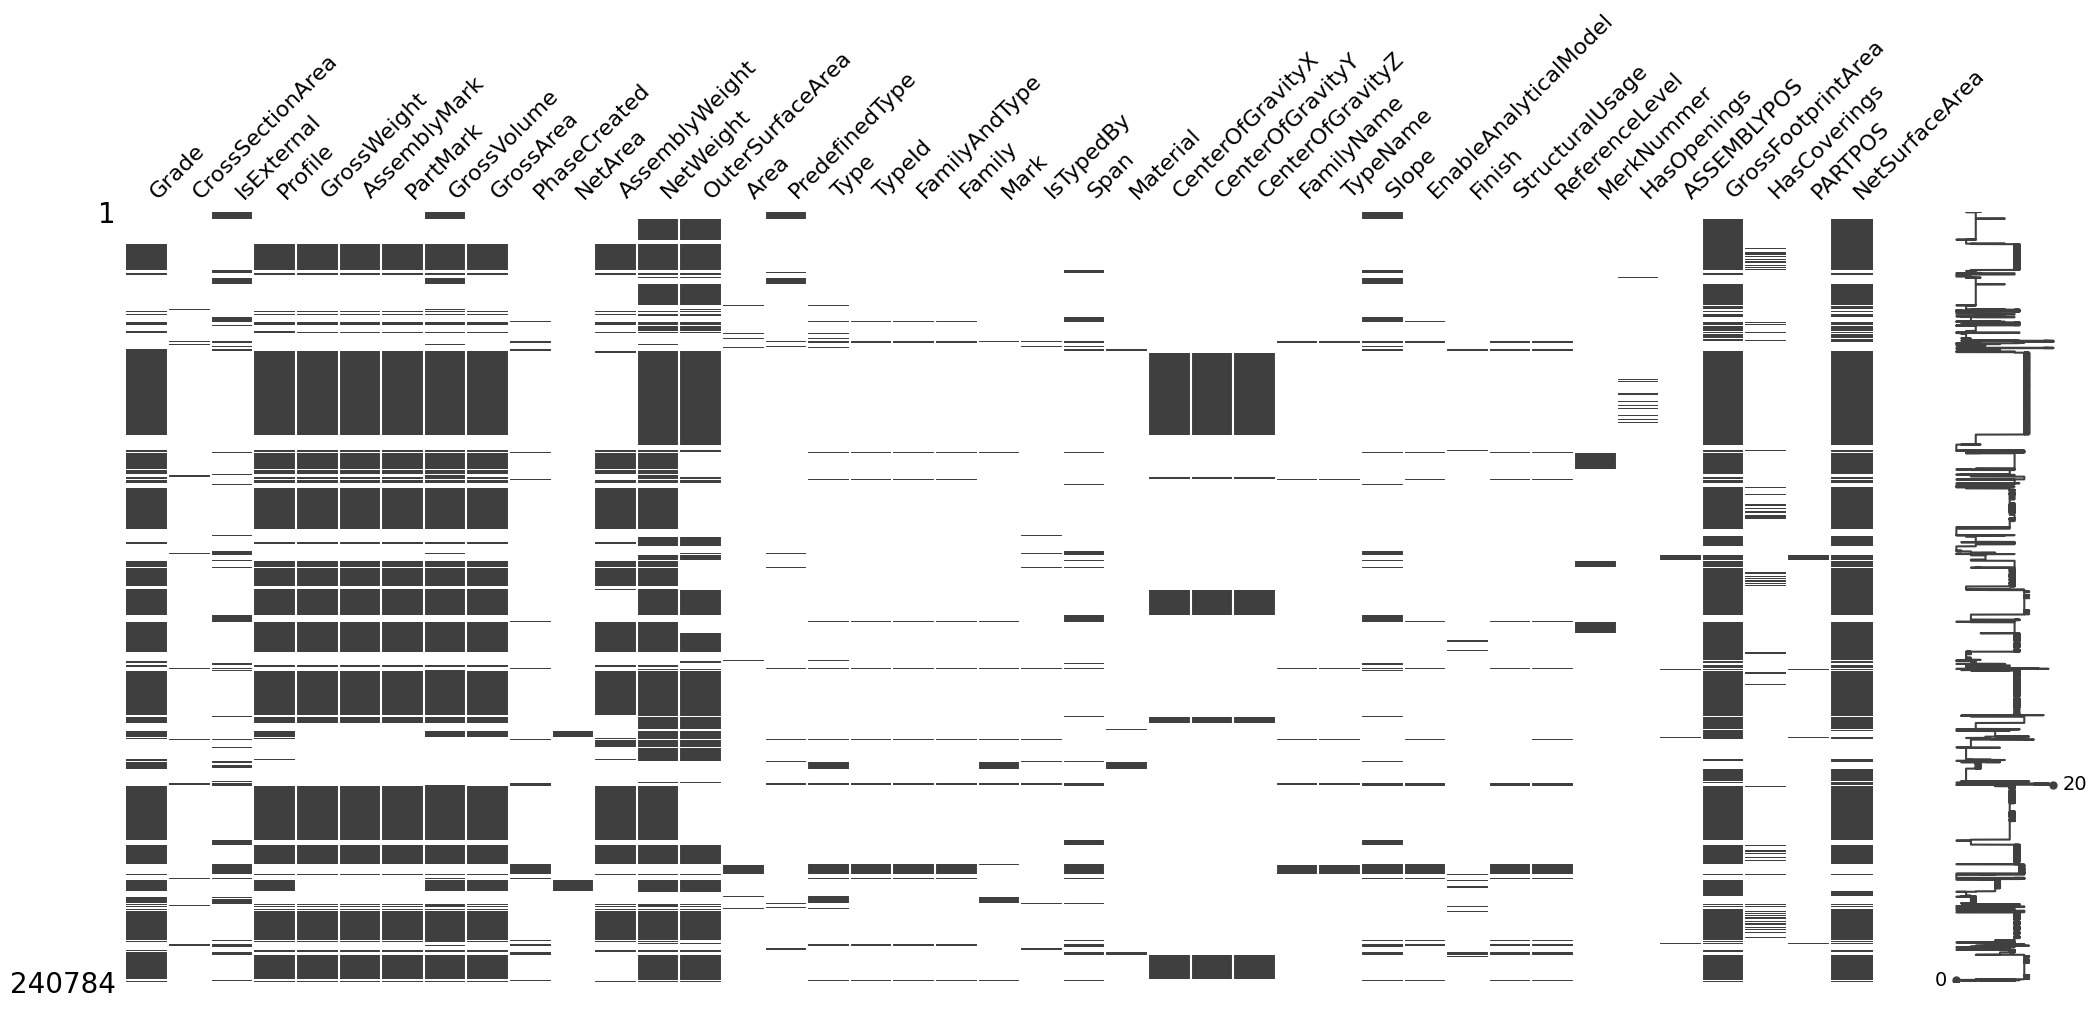

In [189]:
import missingno as msn
msn.matrix(df_beams.iloc[:, :50])
msn.matrix(df_beams.iloc[:, 50:])

Сохраняем данные по балкам

In [190]:
df_beams.to_csv("data/IFC_2000_300_Columns_Beams.csv")

## Здания с большим количеством балок

In [201]:
df_many_beams = df_beams.dropna(subset=['NetWeight'])\
    .value_counts('Filename').head(10)
df_many_beams

Filename
12184-P_Luchtwachttoren_Bladel_V2_ifc      25631
Prefab_ifc                                 16692
Uitbreiding_stadion_Heracles-Almelo_ifc    13927
SantoryTest1_ifc                           12482
BIM_model_ifc                              12121
bouwlaag_1_ifc                              8733
kelder_ifc                                  8038
14765_SB_Kerk_GG_Opheusden (1)_ifc          7652
14765_SB_Kerk_GG_Opheusden_ifc              7652
bouwlaag_2_ifc                              6097
Name: count, dtype: int64

In [211]:
df_selection = df_full[df_full['Filename'].isin(df_many_beams.index)].copy()
df_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344877 entries, 20023 to 1497397
Columns: 218 entries, Filename to NetSurfaceArea
dtypes: float64(82), object(136)
memory usage: 576.2+ MB


In [212]:
drop_almost_missing_columns(df_selection)

Drop Almost Missing: ['IsExternal' 'PhaseCreated' 'Area' 'Type' 'Category' 'HasAssignments'
 'Level' 'TypeId' 'FamilyAndType' 'Family' 'Mark' 'Offset' 'IsTypedBy'
 'Manufacturer' 'Span' 'Host' 'ConnectedFrom' 'ExtendToStructure' 'Size'
 'Material' 'ConnectedTo' 'FamilyName' 'TypeName' 'ThermalTransmittance'
 'BarLength' 'Slope' 'SystemName' 'CompositionType' 'Roughness' 'HostId'
 'EnableAnalyticalModel' 'Finish' 'SystemType' 'HasPorts' 'BaseOffset'
 'RoomBounding' 'OmniClassTitle' 'OmniClassNumber' 'OverallWidth'
 'OverallHeight' 'StructuralUsage' 'TopOffset' 'FlowDirection'
 'ContainedIn' 'NominalWidth' 'NominalHeight' 'ReferenceLevel'
 'ModelReference' 'Thickness' 'WarrantyStartDate' 'InstallationDate'
 'Angle' 'RelatedToMass' 'Color' 'Workset' 'magiSystemCode'
 'magiSystemName' 'Shape' 'Structural' 'MagiInstallationElevation'
 'MagiInstallationElevationAbs' 'MerkNummer' 'HasOpenings' 'LocationLine'
 'UnconnectedHeight' 'BaseConstraint' 'TopExtensionDistance'
 'BaseExtensionDistance'

In [213]:
drop_constant_columns(df_selection)

Drop Constants: ['IFCVersion', 'OwnerHistory', 'Site', 'LoadBearing', 'Location', 'SlottedHoleX']


In [215]:
df_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344877 entries, 20023 to 1497397
Data columns (total 82 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Filename              344877 non-null  object 
 1   IfcEntity             344877 non-null  object 
 2   UniqueID              344877 non-null  float64
 3   GlobalId              344877 non-null  object 
 4   ObjectPlacement       344877 non-null  float64
 5   Representation        344877 non-null  float64
 6   Parent                344877 non-null  object 
 7   Name                  344877 non-null  object 
 8   BuildingStorey        344877 non-null  object 
 9   BoundingBoxMinX       331030 non-null  float64
 10  BoundingBoxMinY       331030 non-null  float64
 11  BoundingBoxMinZ       331030 non-null  float64
 12  BoundingBoxMaxX       331030 non-null  float64
 13  BoundingBoxMaxY       331030 non-null  float64
 14  BoundingBoxMaxZ       331030 non-null  float64
 15  

In [214]:
df_selection.to_csv("data/IFC_2000_300_Columns_Selection.csv")